In [1]:
%load_ext autoreload 
%autoreload 2 
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import sklearn as sk 
import os 
import sys 
from IPython.display import display, Audio
import librosa

import torch
from torch import nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader
# from torchaudio import transforms as trans


In [3]:
import os
import glob
import csv
import re
import itertools
import sys


import numpy
# from import
from tqdm import tqdm
from sklearn import metrics
# original lib
import common as com
import keras_model

2021-11-16 13:14:27.417709: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [4]:
import common as com
from train import *
from test import *

In [5]:
param = com.yaml_load()

In [6]:
mode = True

# make output result directory
os.makedirs(param["result_directory"], exist_ok=True)

# load base directory
dirs = com.select_dirs(param=param, mode=mode)

# initialize lines in csv for AUC and pAUC
csv_lines = []


idx = 0
target_dir = dirs[0]
model_file = '/home/jovyan/code/dcase2020_task2_baseline/model/model_slider_161121_152557.hdf5'

2021-11-16 13:14:31,919 - INFO - load_directory <- development


In [7]:
# loop of the base directory
# for idx, target_dir in enumerate(dirs):
print("\n===========================")
print("[{idx}/{total}] {dirname}".format(dirname=target_dir, idx=idx+1, total=len(dirs)))
machine_type = os.path.split(target_dir)[1]

print("============== MODEL LOAD ==============")
# set model path
# model_file = "{model}/model_{machine_type}.hdf5".format(model=param["model_directory"], 
#                                                         machine_type=machine_type)

# load model file
model = keras_model.load_model(model_file)
# model.summary()

if mode:
    # results by type
    csv_lines.append([machine_type])
    csv_lines.append(["id", "AUC", "pAUC"])
    performance = []

machine_id_list = get_machine_id_list_for_test(target_dir)


[1/1] /home/jovyan/data/dcase20/dev/slider
============== MODEL LOAD ==============


2021-11-16 13:14:32.208849: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-11-16 13:14:32.208903: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-16 13:14:32.208930: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (test-server-0): /proc/driver/nvidia/version does not exist
2021-11-16 13:14:32.209177: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-16 13:14:32.217774: I tensorfl

In [8]:
machine_id_list

['id_00', 'id_02', 'id_04', 'id_06']

In [9]:
# for id_str in machine_id_list:
id_str = machine_id_list[0]

# load test file
test_files, y_true = test_file_list_generator(target_dir, id_str, mode)

# setup anomaly score file path
anomaly_score_csv = "{result}/anomaly_score_{machine_type}_{id_str}.csv".format(
                                                                         result=param["result_directory"],
                                                                         machine_type=machine_type,
                                                                         id_str=id_str)
anomaly_score_list = []

print("\n============== BEGIN TEST FOR A MACHINE ID ==============")
y_pred = [0. for k in test_files]

2021-11-16 13:14:34,503 - INFO - target_dir : /home/jovyan/data/dcase20/dev/slider_id_00
2021-11-16 13:14:34,510 - INFO - test_file  num : 456




============== BEGIN TEST FOR A MACHINE ID ==============


In [11]:
file_path = test_files[0]
data = com.file_to_vector_array(file_path,
                                n_mels=param["feature"]["n_mels"],
                                frames=param["feature"]["frames"],
                                n_fft=param["feature"]["n_fft"],
                                hop_length=param["feature"]["hop_length"],
                                power=param["feature"]["power"])

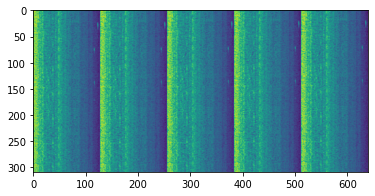

In [14]:
plt.imshow(data)

In [16]:
errors = numpy.mean(numpy.square(data - model.predict(data)), axis=1)
print(numpy.mean(errors))
print(os.path.basename(file_path), y_pred[0])

9.143355031468609
normal_id_00_00000000.wav 0.0


In [17]:
for file_idx, file_path in tqdm(enumerate(test_files), total=len(test_files)):
    try:
        data = com.file_to_vector_array(file_path,
                                        n_mels=param["feature"]["n_mels"],
                                        frames=param["feature"]["frames"],
                                        n_fft=param["feature"]["n_fft"],
                                        hop_length=param["feature"]["hop_length"],
                                        power=param["feature"]["power"])
        errors = numpy.mean(numpy.square(data - model.predict(data)), axis=1)
        y_pred[file_idx] = numpy.mean(errors)
        anomaly_score_list.append([os.path.basename(file_path), y_pred[file_idx]])
    except:
        com.logger.error("file broken!!: {}".format(file_path))

100%|██████████| 456/456 [02:56<00:00,  2.58it/s]


In [18]:
# save anomaly score
save_csv(save_file_path=anomaly_score_csv, save_data=anomaly_score_list)
com.logger.info("anomaly score result ->  {}".format(anomaly_score_csv))

if mode:
    # append AUC and pAUC to lists
    auc = metrics.roc_auc_score(y_true, y_pred)
    p_auc = metrics.roc_auc_score(y_true, y_pred, max_fpr=param["max_fpr"])
    csv_lines.append([id_str.split("_", 1)[1], auc, p_auc])
    performance.append([auc, p_auc])
    com.logger.info("AUC : {}".format(auc))
    com.logger.info("pAUC : {}".format(p_auc))

print("\n============ END OF TEST FOR A MACHINE ID ============")

2021-11-16 13:30:09,788 - INFO - anomaly score result ->  /home/jovyan/code/dcase2020_task2_baseline/result/anomaly_score_slider_id_00.csv
2021-11-16 13:30:09,798 - INFO - AUC : 0.9485112359550562
2021-11-16 13:30:09,799 - INFO - pAUC : 0.7646363098758131



============ END OF TEST FOR A MACHINE ID ============


In [ ]:
if mode:
    # calculate averages for AUCs and pAUCs
    averaged_performance = numpy.mean(numpy.array(performance, dtype=float), axis=0)
    csv_lines.append(["Average"] + list(averaged_performance))
    csv_lines.append([])

In [ ]:
if mode:
    # output results
    result_path = "{result}/{file_name}".format(result=param["result_directory"], file_name=param["result_file"])
    com.logger.info("AUC and pAUC results -> {}".format(result_path))
    save_csv(save_file_path=result_path, save_data=csv_lines)

In [59]:
score_norm = [score[1] for score in anomaly_score_list if 'normal' in score[0]]
score_anom = [score[1] for score in anomaly_score_list if 'anomaly' in score[0]]

assert len(score_norm) + len(score_anom) == len(anomaly_score_list)

N_norm = len(score_norm)
N_anom = len(score_anom)

score_norm = np.array(sorted(score_norm, reverse=True))
score_anom = np.array(sorted(score_anom, reverse=True))

In [62]:
S = 0
for s_anom in score_anom:
    for s_norm in score_norm:
        if s_anom > s_norm: S += 1
        
S = S / (N_norm * N_anom)

In [84]:
raw_scores = [score[1] for score in anomaly_score_list]
roc = sk.metrics.roc_curve(y_true, raw_scores)

In [79]:
roc[0]

array([0.  , 0.  , 0.  , 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.04, 0.04,
       0.05, 0.05, 0.06, 0.06, 0.07, 0.07, 0.08, 0.08, 0.09, 0.09, 0.1 ,
       0.1 , 0.11, 0.11, 0.12, 0.12, 0.13, 0.13, 0.14, 0.14, 0.15, 0.15,
       0.16, 0.16, 0.17, 0.17, 0.19, 0.19, 0.21, 0.21, 0.24, 0.24, 0.29,
       0.29, 1.  ])

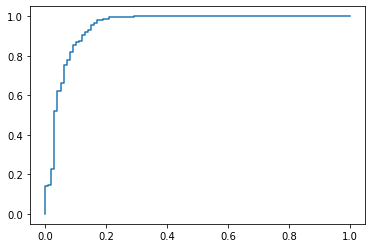

In [82]:
plt.plot(roc[0], roc[1])

In [90]:
roc[2]

array([23.76042555, 22.76042555, 17.78028827, 17.75622832, 17.71745734,
       17.68988096, 16.44716577, 16.3985513 , 14.27052003, 14.26671206,
       13.4127193 , 13.39647919, 13.25679527, 13.24507304, 12.73420235,
       12.71880471, 12.57526652, 12.5721987 , 12.42291345, 12.39869249,
       12.12536508, 12.12283798, 12.08599989, 12.08214334, 12.03018757,
       11.98641856, 11.8925855 , 11.88448295, 11.80219828, 11.80055989,
       11.75330043, 11.73826717, 11.60961536, 11.60722895, 11.51041914,
       11.47107787, 11.15205774, 11.08702732, 11.01152062, 10.86926848,
       10.63055454, 10.44611047, 10.43603024, 10.15043992, 10.14379978,
        8.40126767])

In [142]:
all_scores = np.sort(np.stack([y_pred, y_true], axis=1), axis=0)[::-1]
print(all_scores[:10])

[[22.76042555  1.        ]
 [22.53295169  1.        ]
 [22.39082914  1.        ]
 [21.90330048  1.        ]
 [21.41029927  1.        ]
 [21.22616358  1.        ]
 [21.0814856   1.        ]
 [21.0538215   1.        ]
 [20.83014743  1.        ]
 [20.51751222  1.        ]]


In [155]:
1 - all_scores[:5][:, 1]

array([0., 0., 0., 0., 0.])

In [153]:
np.sum(all_scores[:4][:, 1])

4.0

In [163]:
TP, FP = [], []
for i in range(all_scores.shape[0]):
#     print(i, all_scores[i, 0], all_scores[i, 1])
    tp = np.sum(all_scores[:i][:, 1]) / N_anom
    fp = np.sum(1 - all_scores[i:][:, 1]) / N_norm
    TP += [tp]
    FP += [fp]
    

0.99